In [204]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(1,'./../../../sfmbv')


import methods
import matplotlib.pyplot as plt
import networkx as nx
import scipy
import numpy as np
import betterspy

import qtree_methods as qtm

from sklearn.cluster import KMeans

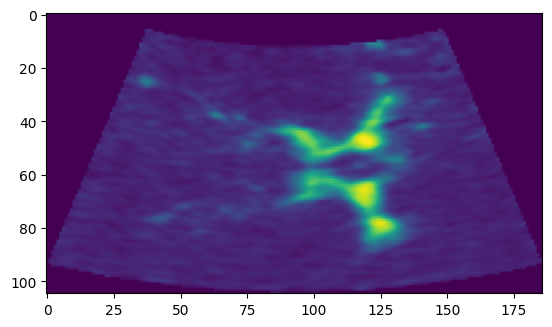

In [205]:
SLICE = 50
bias = 10

img_array, _ = methods.pd(zoom = 1, base='wl1_5')
# img_array, _ = methods.pd_3d(zoom=0.3)
mask_array = img_array > 0

plt.imshow(img_array[:,:])
# plt.imshow(img_array[:,SLICE,:])

In [206]:
wf = methods.WeightKernel(
    dist_sig = 1,
    intensity_sig = 40
)

# problem with mask?
G = methods.ImageGraph(
    img_array, 
    # mask_array=mask_array, 
    mask_array=mask_array,
    wf=wf, 
    neighbour_depth = 2, 
    cmap='viridis'
    )

In [207]:
# Create zero_node...

G._create_zero_node(zero_node_threshold=30)

In [208]:
# nx.write_gexf(G, 'zero-node.gexf')

In [209]:
# nx.write_gexf(G, 'cow.gexf')

In [210]:
P = nx.normalized_laplacian_matrix(G)
N = P.shape[0]

In [211]:
print(N)
print(P.nnz/N**2)

13937
0.0010515189075220662


In [212]:
solve_matrix = -(P-scipy.sparse.identity(N))
# %timeit vals, vecs = scipy.sparse.linalg.eigs(solve_matrix, which='LM')
vals, vecs = scipy.sparse.linalg.eigs(solve_matrix, which='LR')

In [213]:
# %timeit vals, vecs = scipy.sparse.linalg.eigs(P, which='SR')

In [214]:
i = 4
eig_img = methods.node_vec_to_img_array(G,np.real(vecs[:,i]))

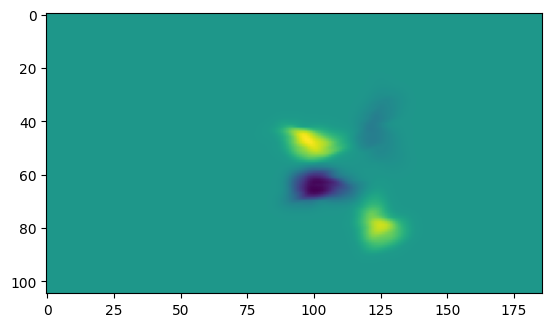

In [215]:
plt.imshow(eig_img[:,:])


/Users/jackh/opt/anaconda3/envs/gordon_original/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


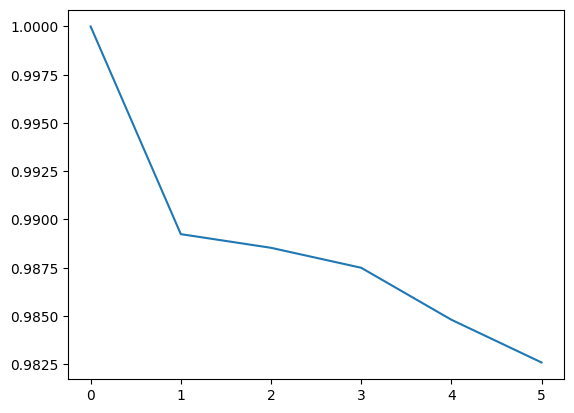

In [216]:
plt.plot(vals)

In [217]:
cluster_num = 5

kmeans = KMeans(n_clusters=cluster_num, random_state=0, n_init="auto").fit(np.real(vecs[:,:3]))
labels = kmeans.labels_+1

In [218]:
k_img = methods.node_vec_to_img_array(G,labels)

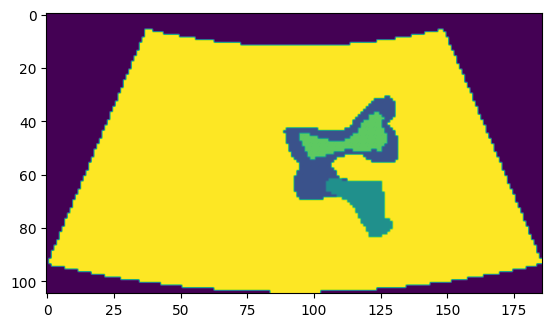

In [219]:
plt.imshow(k_img[:,:])

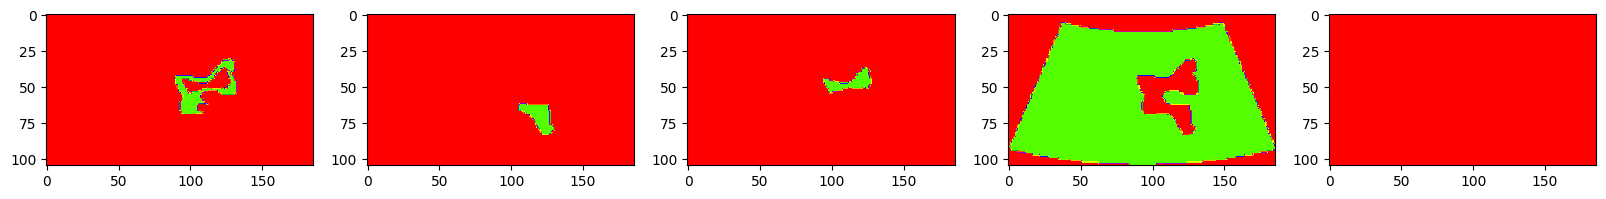

In [220]:

fig, axs = plt.subplots(1, cluster_num) 
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(1,cluster_num+1):
    curr = k_img == i
    axs[i-1].imshow(curr[:,:], cmap='prism')

In [221]:
S, R  = methods.SEBA(np.real(vecs)[:,:3])

In [222]:
seba_sum =  np.sum(S, axis=1)
seba_img = methods.node_vec_to_img_array(G,seba_sum)

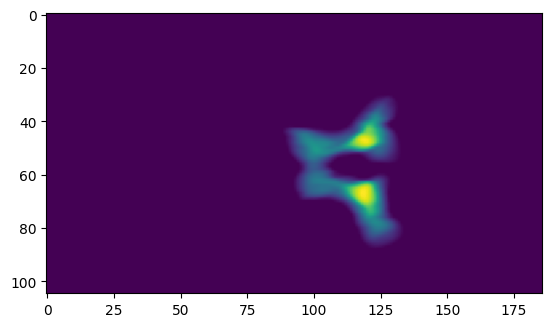

In [223]:
plt.imshow(seba_img[:,:])

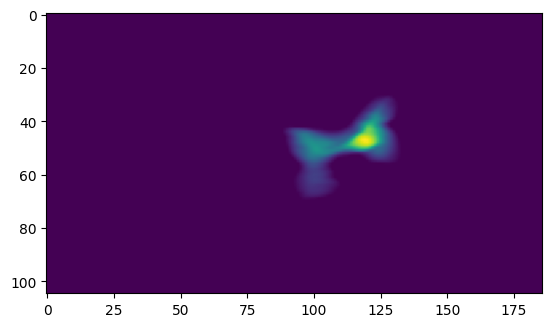

In [224]:
seba_component_img = methods.node_vec_to_img_array(G,S[:,2])
plt.imshow(seba_component_img[:,:])

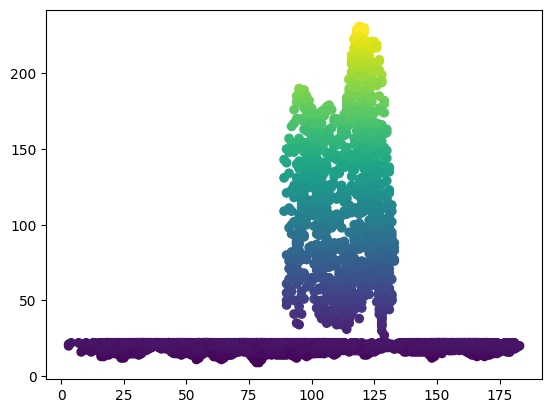

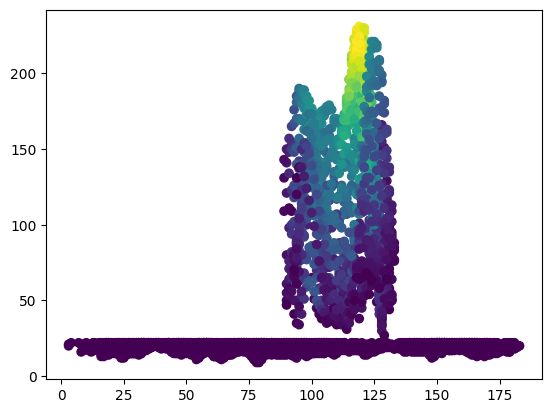

In [225]:
# TRACE DRAFT

def show_trace(img, mask = None, axis=0):
    if mask is None:
        mask = np.full(img.shape, True)
    
    # assert
    mask_color = mask

    mask_flat = (mask > 0).flatten()
    img_flat = img.flatten()
    mask_color_flat = mask_color.flatten()

    xys = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
    
    d_flat = xys[axis].flatten()

    plt.figure()
    plt.scatter(d_flat[mask_flat], img_flat[mask_flat], c = img_flat[mask_flat])

    plt.figure()
    plt.scatter(d_flat[mask_flat], img_flat[mask_flat], c = mask_color_flat[mask_flat])


show_trace(img_array, mask = seba_img, axis=0)

In [226]:
sh = (2,3,4)
img_array = np.random.rand(*sh)

print(img_array)

msk = np.full(sh, False)
msk[int(sh[0]*.5):,:int(sh[1]*.5)+1,:] = True
print(msk)

F = methods.ImageGraph(img_array, mask_array=None)

node_vec = methods.img_array_to_node_vec(F, img_array)

print(node_vec)

# test against v_coords
for i in range(len(node_vec)):
    # assert node_vec[i] == img_array[*G.v_coords[G.list_nodes[i],:]]
    assert node_vec[i] == img_array[*F.v_coords[F.list_nodes[i],:]]

print(len(node_vec))
print(G.v_coords.shape)

[[[0.5386354  0.70570129 0.02568689 0.03667191]
  [0.78293295 0.69415816 0.92514457 0.22263171]
  [0.3158827  0.60901243 0.94096943 0.74729901]]

 [[0.31552278 0.97968979 0.24377222 0.62361359]
  [0.81463878 0.66564586 0.46215862 0.95460682]
  [0.46282463 0.86378105 0.14592208 0.64273577]]]
[[[False False False False]
  [False False False False]
  [False False False False]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [False False False False]]]
[0.5386354  0.70570129 0.31552278 0.97968979 0.78293295 0.66564586
 0.69415816 0.81463878 0.3158827  0.86378105 0.46282463 0.60901243
 0.24377222 0.02568689 0.46215862 0.92514457 0.94096943 0.14592208
 0.62361359 0.03667191 0.95460682 0.22263171 0.74729901 0.64273577]
24
(19530, 2)


In [227]:
node_vec

array([0.5386354 , 0.70570129, 0.31552278, 0.97968979, 0.78293295,
       0.66564586, 0.69415816, 0.81463878, 0.3158827 , 0.86378105,
       0.46282463, 0.60901243, 0.24377222, 0.02568689, 0.46215862,
       0.92514457, 0.94096943, 0.14592208, 0.62361359, 0.03667191,
       0.95460682, 0.22263171, 0.74729901, 0.64273577])

In [228]:
# print(node_vec)
# print(img_array.flatten())
# print((node_vec == img_array.flatten()).all())

In [229]:
print(F.v_coords)

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 2 0]
 [0 2 1]
 [0 2 2]
 [0 2 3]
 [1 0 0]
 [1 0 1]
 [1 0 2]
 [1 0 3]
 [1 1 0]
 [1 1 1]
 [1 1 2]
 [1 1 3]
 [1 2 0]
 [1 2 1]
 [1 2 2]
 [1 2 3]]


In [230]:
a = np.meshgrid(*[range(sh[i]) for i in range(len(sh))], indexing='ij')
a[0].flatten(order='F')
# print(a[0].shape)
# print(a[0])

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1])

In [231]:
print(node_vec)
# print(G.img_array[1,0,0])
# print(G.img_array[*G.v_coords[1,:]])

[0.5386354  0.70570129 0.31552278 0.97968979 0.78293295 0.66564586
 0.69415816 0.81463878 0.3158827  0.86378105 0.46282463 0.60901243
 0.24377222 0.02568689 0.46215862 0.92514457 0.94096943 0.14592208
 0.62361359 0.03667191 0.95460682 0.22263171 0.74729901 0.64273577]


In [232]:
print(img_array.flatten())
img_array.flatten().reshape(*img_array.shape)

[0.5386354  0.70570129 0.02568689 0.03667191 0.78293295 0.69415816
 0.92514457 0.22263171 0.3158827  0.60901243 0.94096943 0.74729901
 0.31552278 0.97968979 0.24377222 0.62361359 0.81463878 0.66564586
 0.46215862 0.95460682 0.46282463 0.86378105 0.14592208 0.64273577]


array([[[0.5386354 , 0.70570129, 0.02568689, 0.03667191],
        [0.78293295, 0.69415816, 0.92514457, 0.22263171],
        [0.3158827 , 0.60901243, 0.94096943, 0.74729901]],

       [[0.31552278, 0.97968979, 0.24377222, 0.62361359],
        [0.81463878, 0.66564586, 0.46215862, 0.95460682],
        [0.46282463, 0.86378105, 0.14592208, 0.64273577]]])

In [233]:
post_array = methods.node_vec_to_img_array(F, node_vec)

print(post_array)

[[[0.5386354  0.70570129 0.02568689 0.03667191]
  [0.78293295 0.69415816 0.92514457 0.22263171]
  [0.3158827  0.60901243 0.94096943 0.74729901]]

 [[0.31552278 0.97968979 0.24377222 0.62361359]
  [0.81463878 0.66564586 0.46215862 0.95460682]
  [0.46282463 0.86378105 0.14592208 0.64273577]]]


In [234]:
F.nodes

NodeView((0, 1, 12, 13, 4, 17, 5, 16, 8, 21, 20, 9, 14, 2, 18, 6, 10, 22, 15, 3, 19, 7, 11, 23))

In [235]:
img_array == post_array

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

In [236]:
# tmp = img_array.reshape(1,-1).T